In [1]:
!pip install umap-learn

   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/88.8 kB ? eta -:--:--
   ------------------ --------------------- 41.0/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------- ------- 71.7/88.8 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 88.8/88.8 kB 162.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? et

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import torch
import collections
from sklearn import metrics
# import seaborn as sns
import umap.umap_ as umap

e:\Users\abolf\anaconda3\envs\general\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!unzip '/content/drive/MyDrive/cora.zip'

Archive:  /content/drive/MyDrive/cora.zip
   creating: cora/
   creating: cora/cora/
  inflating: cora/cora/cora.cites    
  inflating: cora/cora/cora.content  
  inflating: cora/cora/README        


In [47]:
edgelist = pd.read_csv('/content/cora/cora/cora.cites', sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
edgelist.sample(frac=1).head(5)

,target,source,label
3052,40124,1104258,cites
3215,49482,7297,cites
1061,4804,102884,cites
5118,612306,193347,cites
2908,35922,390896,cites


In [48]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]

column_names =  feature_names + ["subject"]
node_data = pd.read_csv('/content/cora/cora/cora.content', sep='\t', header=None, names=column_names)

node_data.sample(frac=1).head(5)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
1153280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
112378,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based
1153724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based
1071981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
240321,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Neural_Networks


In [49]:
def reset_index(node_data):
  reset_Index = {}
  reset_id = 0
  for index, row in node_data.iterrows():
    reset_Index[index] = reset_id
    reset_id += 1

  return reset_Index

reset_ids = reset_index(node_data)
node_data.index = node_data.index.map(reset_ids)
edgelist.source = edgelist.source.map(reset_ids)
edgelist.target = edgelist.target.map(reset_ids)

In [50]:
print(f'Number of nodes:{node_data.shape[0]}')
print(f'Number of edges:{edgelist.shape[0]}')

Number of nodes:2708
Number of edges:5429


In [51]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
adjmatrix = nx.adjacency_matrix(Gnx, nodelist=node_data.index).todense()

In [52]:
def has_isolated_nodes(adjmatrix):
  N = adjmatrix.shape[0]
  for i in range(N):
    if np.all(adjmatrix[i] == 0):
      return True
  return False

def has_self_loops(adjmatrix):
  N = adjmatrix.shape[0]
  for i in range(N):
    if adjmatrix[i][i] == 1:
      return True
  return False


def is_undirected(adjmatrix):
  N = adjmatrix.shape[0]
  for i in range(N):
    for j in range(i + 1):
      if adjmatrix[i][j] != adjmatrix[j][i]:
        return False
  return True

print(f'Has isolated nodes: {has_isolated_nodes(adjmatrix)}')  # False
print(f'Has self-loops: {has_self_loops(adjmatrix)}')  # False
print(f'Is undirected: {is_undirected(adjmatrix)}')  # True

print(f'Average node degree: {2*Gnx.number_of_edges() / Gnx.number_of_nodes():.2f}') #Average node degree: 3.90


Has isolated nodes: False
Has self-loops: False
Is undirected: True
Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


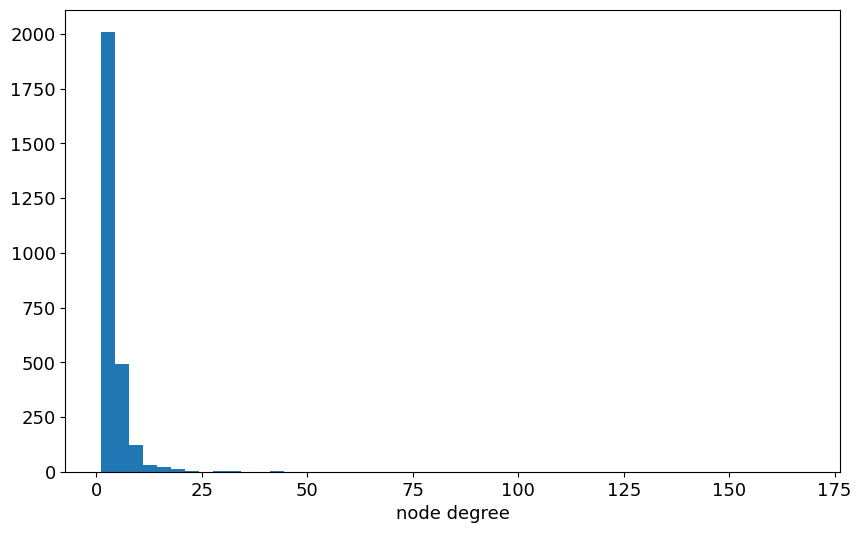

In [ ]:
degrees = [val for (node, val) in Gnx.degree]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.011821204285186553


/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


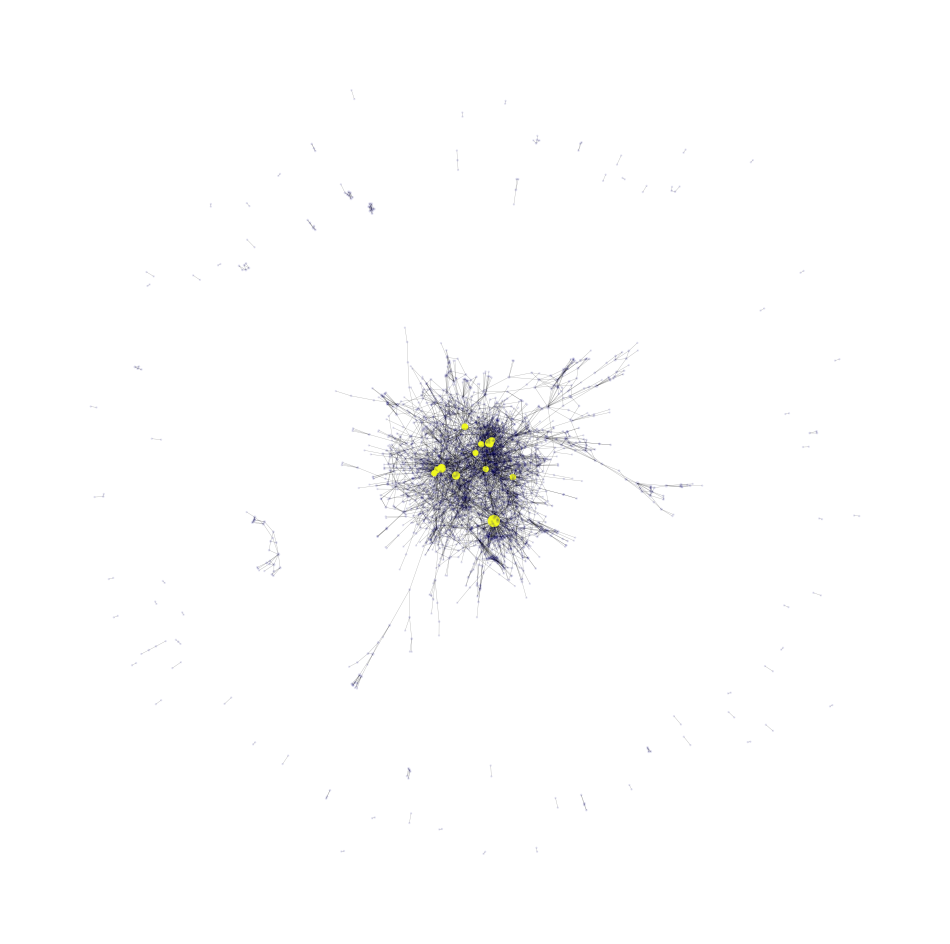

In [54]:
pos = nx.spring_layout(Gnx, seed=42)

cent = nx.degree_centrality(Gnx)

node_size = list(map(lambda x: x * 1000, cent.values()))

cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(Gnx, pos, node_size=node_size, cmap=plt.cm.plasma, node_color=cent_bin, nodelist=list(cent.keys()), alpha=cent_bin)
edges = nx.draw_networkx_edges(Gnx, pos, width=0.25, alpha=0.3)
plt.axis('off')
plt.show()


In [ ]:
## classes ##

num_classes = len(node_data['subject'].unique())
print(f'Number of classes: {num_classes}')



label_dict = {
    "Theory": 0,
    "Reinforcement_Learning": 1,
    "Genetic_Algorithms": 2,
    "Neural_Networks": 3,
    "Probabilistic_Methods": 4,
    "Case_Based": 5,
    "Rule_Learning": 6}

 = np.array(node_data['subject'].map(label_dict))

Number of classes: 7


{np.int64(3): 818, np.int64(6): 180, np.int64(1): 217, np.int64(4): 426, np.int64(0): 351, np.int64(2): 418, np.int64(5): 298}


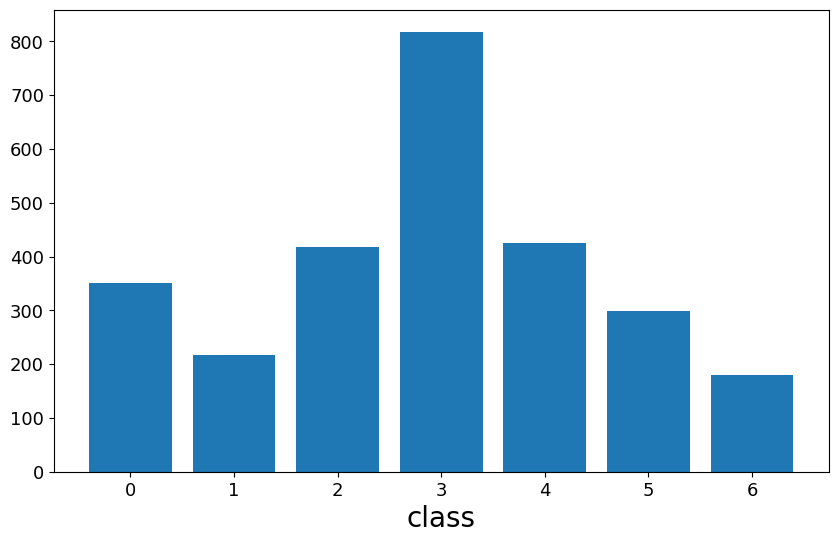

In [ ]:
counter = collections.Counter()

counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]

plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

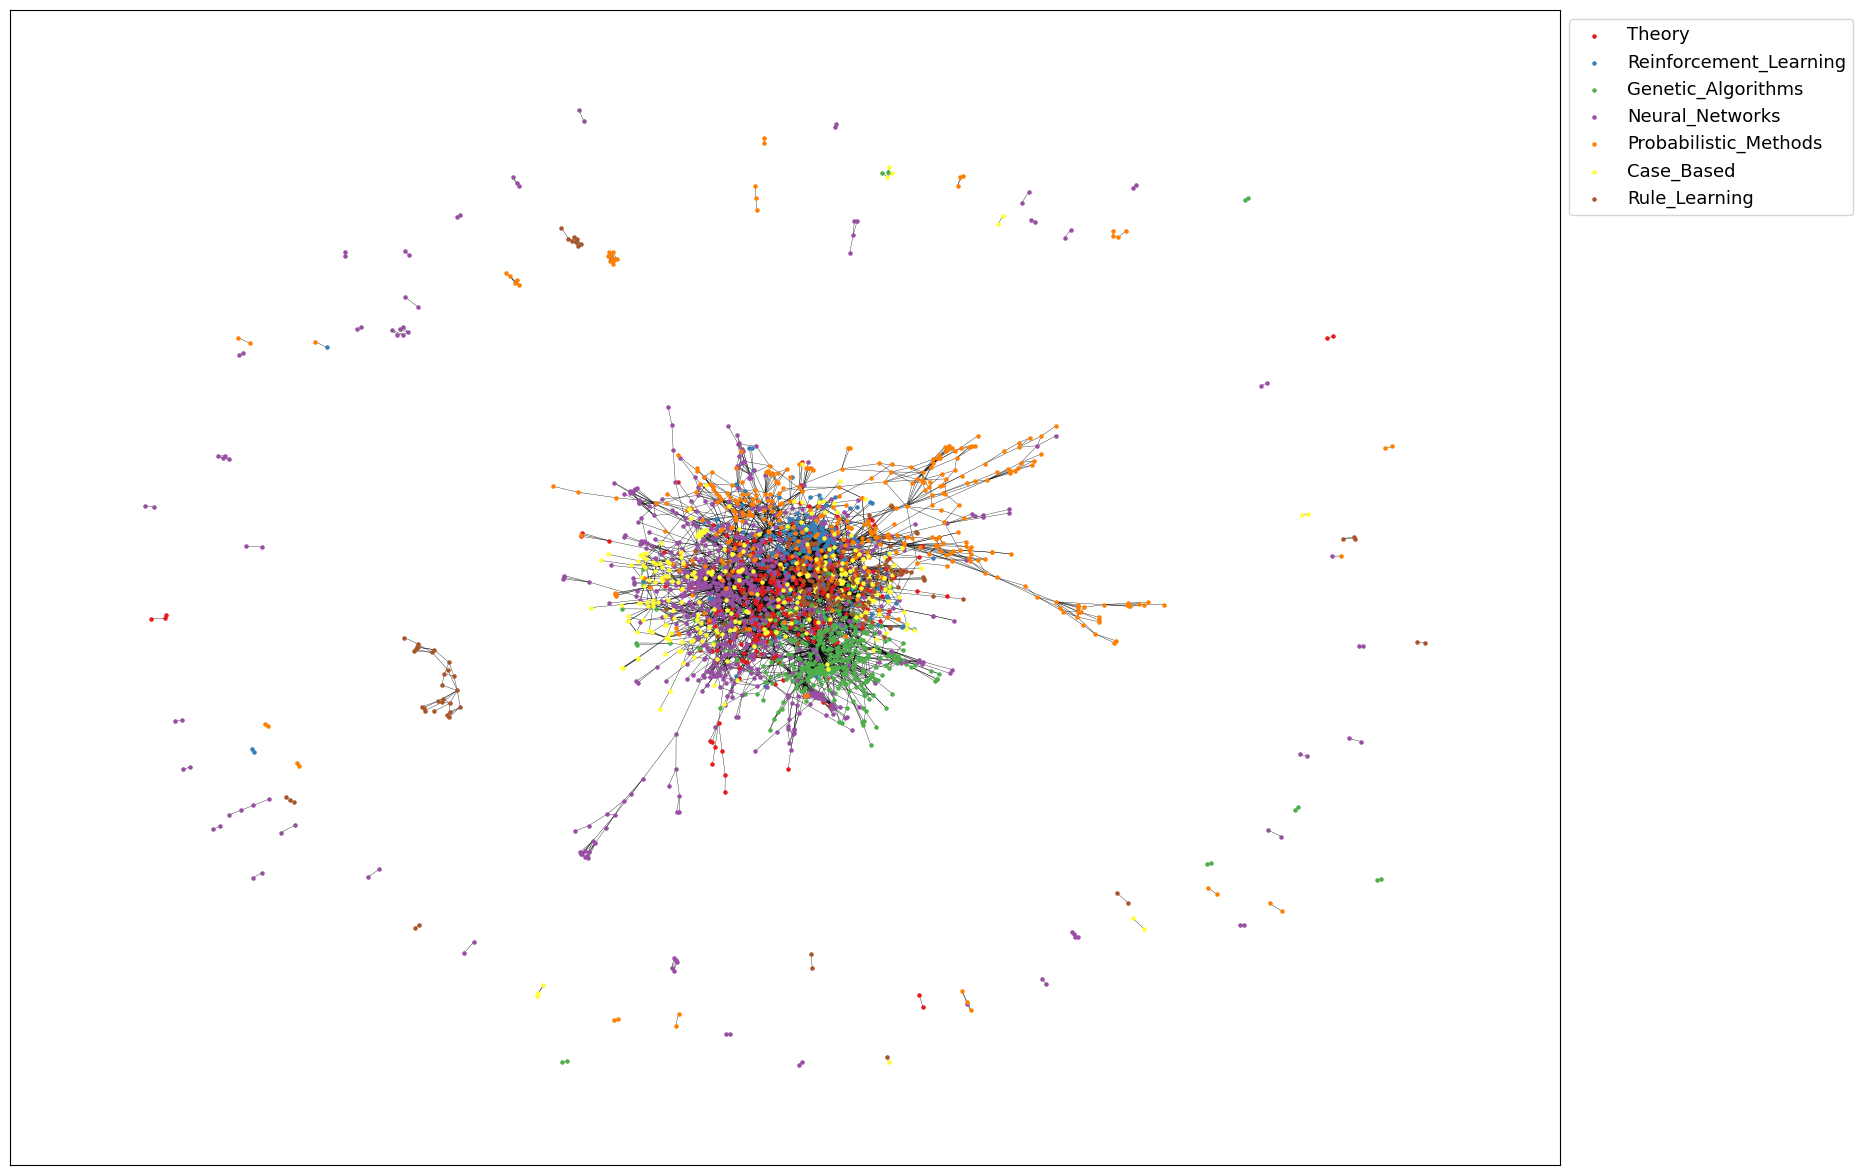

In [57]:
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

for i, c in enumerate(labels):
  node_color.append(colorlist[c])
  nodelist[c].append(i)

pos = nx.spring_layout(Gnx, seed = 42)

plt.figure(figsize = (20, 15))
labellist = list(label_dict.keys())

for i, group in enumerate(zip(nodelist, labellist)):
  nodes, label = group[0], group[1]
  nx.draw_networkx_nodes(Gnx, pos, nodelist=nodes, node_size=5, node_color=colorlist[i], label=label)

nx.draw_networkx_edges(Gnx, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [1]:
label_connection_counts = np.zeros(shape=(7,7))

for u, v, d in Gnx.edges(data=True):
  u_label = node_data.loc[u, 'subject']
  v_label = node_data.loc[v, 'subject']
  i = label_dict[u_label]
  j = label_dict[v_label]
  label_connection_counts[i][j] += 1
  label_connection_counts[j][i] += 1


NameError: name 'np' is not defined

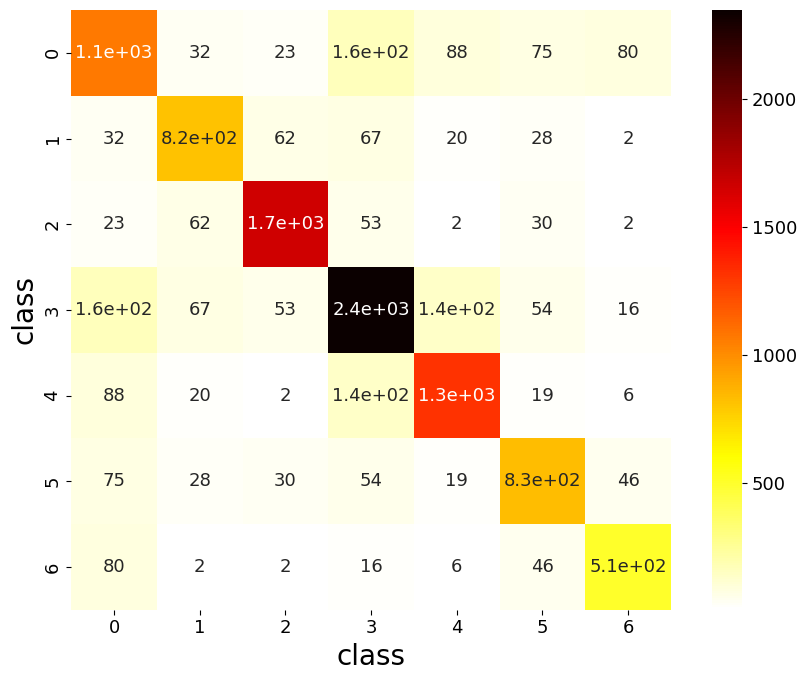

In [ ]:

# cm_ = metrics.ConfusionMatrix(confusion_matrix = label_confusion_matrix, l_dict)

plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()


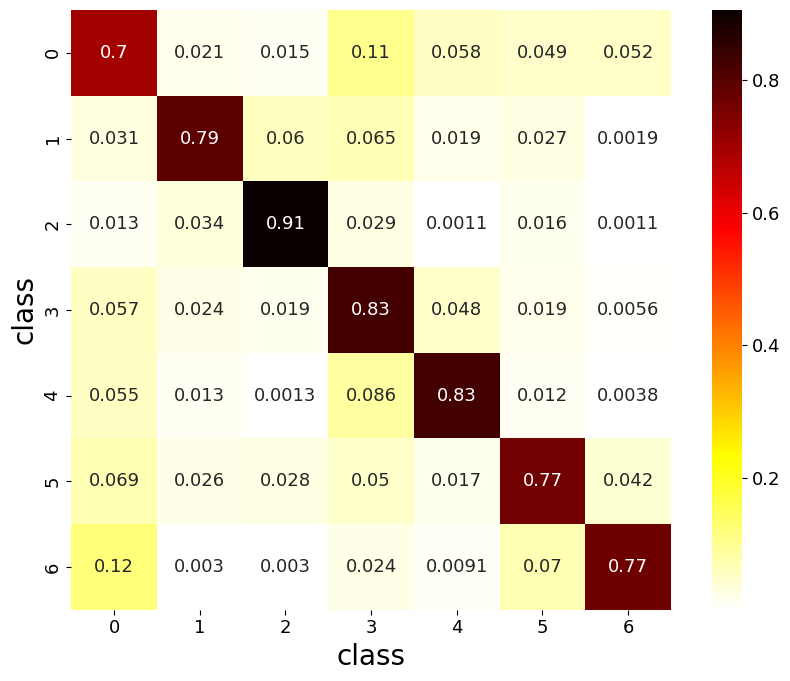

In [60]:
s_r = np.sum(label_connection_counts, axis=1)
scaled_matrix = np.zeros(shape=(7,7))
for i in range(7):
  scaled_row = label_connection_counts[i ,:] / s_r[i]
  scaled_matrix[i] = scaled_row

plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(scaled_matrix, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [61]:
## Spliting data ##

node_status = ["undefined"] * node_data.shape[0]
node_data['node_status'] = node_status

training_rate = 0.6
validation_rate = 0.2
test_rate = 0.2

for index, row in node_data.iterrows():
  p = random.random()
  if p < training_rate:
    node_data.at[index, 'node_status'] = "train"
  elif p < validation_rate + training_rate:
    node_data.at[index, 'node_status'] = "validation"
  else:
    node_data.at[index, 'node_status'] = "test"

In [62]:
print(node_data.where(node_data['node_status'] == "train").dropna().shape)
print(node_data.where(node_data['node_status'] == "validation").dropna().shape)
print(node_data.where(node_data['node_status'] == "test").dropna().shape)

(1622, 1435)
(564, 1435)
(522, 1435)


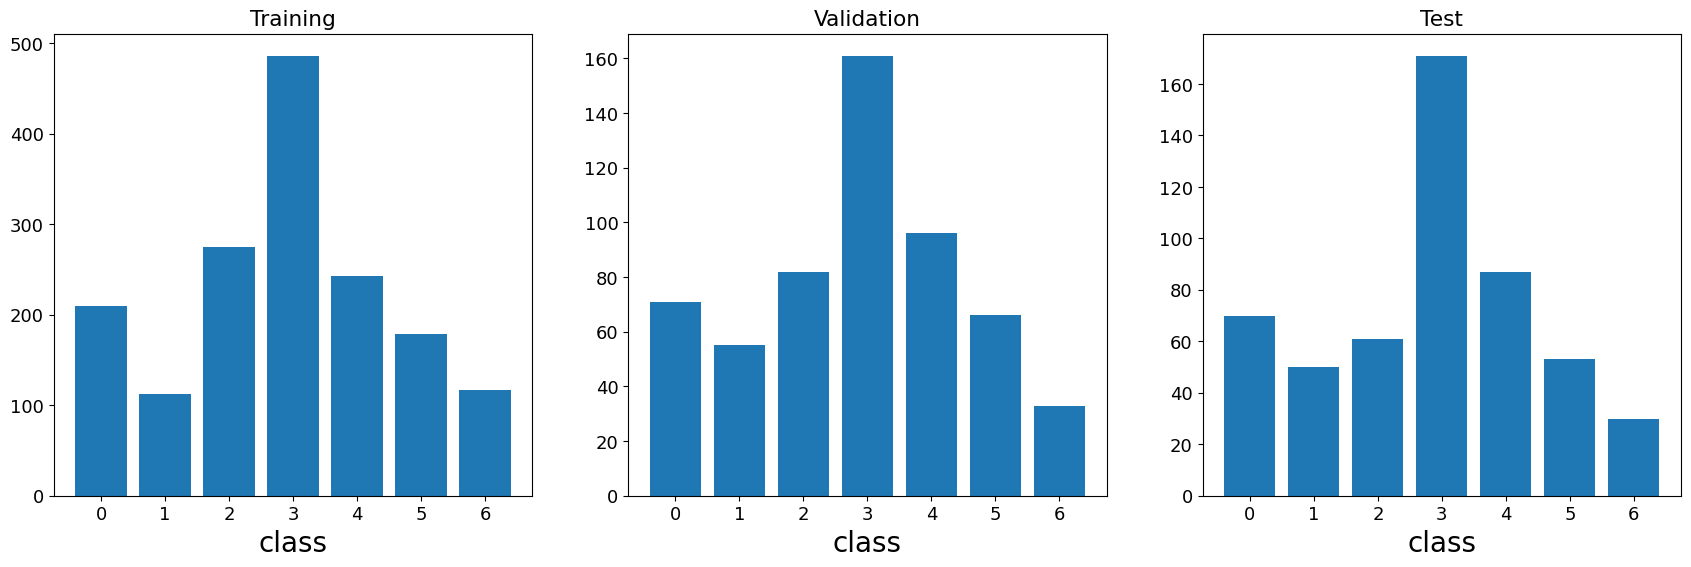

In [63]:

fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
train_index = node_data.where(node_data['node_status'] == 'train' ).dropna().index
val_index = node_data.where(node_data['node_status'] == 'validation' ).dropna().index
test_index = node_data.where(node_data['node_status'] == 'test' ).dropna().index


train_labels = node_data.loc[train_index, 'subject'].map(label_dict)
train_label_counter = dict(collections.Counter(train_labels)).items()
train_label_count = [x[1] for x in sorted(train_label_counter)]

val_labels = node_data.loc[val_index, 'subject'].map(label_dict)
val_label_counter = dict(collections.Counter(val_labels)).items()
val_label_count = [x[1] for x in sorted(val_label_counter)]

test_labels = node_data.loc[test_index, 'subject'].map(label_dict)
test_label_counter = dict(collections.Counter(test_labels)).items()
test_label_count = [x[1] for x in sorted(test_label_counter)]



axes[0].bar(range(7), train_label_count)
axes[0].set_xlabel("class", size=20)
axes[0].set_title("Training")

axes[1].bar(range(7), val_label_count)
axes[1].set_xlabel("class", size=20)
axes[1].set_title("Validation")

axes[2].bar(range(7), test_label_count)
axes[2].set_xlabel("class", size=20)
axes[2].set_title("Test")

plt.show()

In [64]:


feature_data = node_data.drop(columns=['node_status', 'subject']).values
feature_data = torch.tensor(feature_data).float().to('cuda')


y_train = node_data.where(node_data['node_status'] == 'train').dropna()['subject'].map(label_dict).values
y_train = torch.tensor(y_train).to('cuda')

y_val = node_data.where(node_data['node_status'] == 'validation').dropna()['subject'].map(label_dict).values
y_val = torch.tensor(y_val).to('cuda')

y_test = node_data.where(node_data['node_status'] == 'test').dropna()['subject'].map(label_dict).values
y_test = torch.tensor(y_test).to('cuda')

INITIAL_FEATURES = feature_data.shape[1]


In [136]:
class GCN_layer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        # self.normalized_adj = self.normalising_adjmatrix(adjmatrix)
        self.reset_parameter()

    def reset_parameter(self):
      torch.nn.init.xavier_uniform_(self.weight)


    def message_passing(self, x):
      return torch.matmul(x, self.weight)

    def aggregate(self, normalized_adj, x):
      return torch.matmul(normalized_adj, x)


    def forward(self, x, normalized_adj):
      x = self.message_passing(x)
      x = self.aggregate(normalized_adj, x)
      return x





class gcn_classification(torch.nn.Module):
  def __init__(self):
    super(gcn_classification, self).__init__()

    self.gcn1 = GCN_layer(INITIAL_FEATURES, 32)
    self.batch_norm1 = torch.nn.BatchNorm1d(32)
    self.relu1 = torch.nn.ReLU()
    self.drop1 = torch.nn.Dropout(0.5)

    self.gcn2 = GCN_layer(32, 32)
    self.batch_norm2 = torch.nn.BatchNorm1d(32)
    self.relu2 = torch.nn.ReLU()
    self.drop2 = torch.nn.Dropout(0.5)

    self.gcn3 = GCN_layer(32, 32)
    self.batch_norm3 = torch.nn.BatchNorm1d(32)
    self.relu3 = torch.nn.ReLU()
    self.drop3 = torch.nn.Dropout(0.5)

    self.gcn4 = GCN_layer(32, 32)
    self.batch_norm4 = torch.nn.BatchNorm1d(32)
    self.relu4 = torch.nn.ReLU()
    self.drop4 = torch.nn.Dropout(0.5)

    self.gcn5 = GCN_layer(32, 32)
    self.batch_norm5 = torch.nn.BatchNorm1d(32)
    self.relu5 = torch.nn.ReLU()
    self.drop5 = torch.nn.Dropout(0.5)

    self.linear6 = torch.nn.Linear(32, 32)
    self.batch_norm6 = torch.nn.BatchNorm1d(32)
    self.relu6 = torch.nn.ReLU()
    self.drop6 = torch.nn.Dropout(0.5)

    self.linear7 = torch.nn.Linear(32, 32)
    self.softmax = torch.nn.Softmax(dim=1)
    self.embeddings = []

  def normalising_adjmatrix(self, adjmatrix):
      adj_thelda = adjmatrix + torch.eye(adjmatrix.shape[0]).to('cuda')
      D_thelda = torch.sum(adj_thelda, dim=1)
      D_thelda = torch.diag(D_thelda)
      D_thelda_sqrt = torch.sqrt(D_thelda)
      D_thelda_sqrt_inv = torch.linalg.inv(D_thelda_sqrt)
      return torch.matmul(torch.matmul(D_thelda_sqrt_inv, adj_thelda), D_thelda_sqrt_inv)


  def forward(self, x, adjmatrix, node_status):
    normalized_adj = self.normalising_adjmatrix(adjmatrix)
    x = self.gcn1(x, normalized_adj)
    x = self.batch_norm1(x)
    x = self.relu1(x)
    x = self.drop1(x)

    x = self.gcn2(x, normalized_adj)
    x = self.batch_norm2(x)
    x = self.relu2(x)
    x = self.drop2(x)

    # x = self.gcn3(x, normalized_adj)
    # x = self.batch_norm3(x)
    # x = self.relu3(x)
    # x = self.drop3(x)

    # x = self.gcn4(x, normalized_adj)
    # x = self.batch_norm4(x)
    # x = self.relu4(x)
    # x = self.drop4(x)

    # x = self.gcn5(x, normalized_adj)
    # x = self.batch_norm5(x)
    # x = self.relu5(x)
    # x = self.drop5(x)
    # # x = self.gcn4(x, normalized_adj)
    # # x = self.gcn5(x, normalized_adj)
    # # x = self.gcn6(x, normalized_adj)
    self.embeddings.append(x)

    x = x[node_data.where(node_data['node_status'] == node_status).dropna().index]
    x = self.linear6(x)
    x = self.batch_norm6(x)
    x = self.relu6(x)
    x = self.drop6(x)

    x = self.linear7(x)
    x = self.softmax(x)
    return x



class Jumping_GCN(torch.nn.Module):
  def __init__(self) -> None:
    super(Jumping_GCN, self).__init__()
    self.gcn1 = GCN_layer(INITIAL_FEATURES, 32)
    self.batch_norm1 = torch.nn.BatchNorm1d(32)
    self.relu1 = torch.nn.ReLU()
    self.drop1 = torch.nn.Dropout(0.5)

    self.gcn2 = GCN_layer(32,32)
    self.batch_norm2 = torch.nn.BatchNorm1d(32)
    self.relu2 = torch.nn.ReLU()
    self.drop2 = torch.nn.Dropout(0.5)

    self.gcn3 = GCN_layer(32,32)
    self.batch_norm3 = torch.nn.BatchNorm1d(32)
    self.relu3 = torch.nn.ReLU()
    self.drop3 = torch.nn.Dropout(0.5)

    self.gcn4 = GCN_layer(32,32)
    self.batch_norm4 = torch.nn.BatchNorm1d(32)
    self.relu4 = torch.nn.ReLU()
    self.drop4 = torch.nn.Dropout(0.5)

    self.gcn5 = GCN_layer(32,32)
    self.batch_norm4 = torch.nn.BatchNorm1d(32)
    self.relu5 = torch.nn.ReLU()
    self.drop5 = torch.nn.Dropout(0.5)


    self.linear6 = torch.nn.Linear(32,32)
    self.batch_norm6 = torch.nn.BatchNorm1d(32)
    self.relu6 = torch.nn.ReLU()
    self.drop6 = torch.nn.Dropout(0.5)

    self.linear7 = torch.nn.Linear(32,7)
    self.softmax = torch.nn.Softmax(dim=1)
    self.embeddings = []

    self.alphas = torch.nn.Parameter(torch.ones(4))

    self.lstm = torch.nn.LSTM(32, 16, num_layers=1, batch_first=True, bidirectional=True)
    self.linear8 = torch.nn.Linear(32,1)





  def max_pooling(self, gcn_outputs):
    gcn_outputs = torch.stack(gcn_outputs, dim=0)
    return torch.max(gcn_outputs, dim=0)[0]


  def mixture_outputs(self, gcn_outputs):
    gcn_outputs = torch.stack(gcn_outputs, dim=0)
    gcn_outputs = gcn_outputs.permute(2,1,0)
    print(gcn_outputs.shape)
    alphas_prob = torch.softmax(self.alphas, dim=0)
    final_embbeding = torch.matmul(gcn_outputs, alphas_prob)
    return final_embbeding.permute(1,0)

  def lstm_attention(self, gcn_outputs):
    gcn_outputs = torch.stack(gcn_outputs, dim=0)
    gcn_outputs = gcn_outputs.permute(1,0,2)
    output, (hidden_state, cell_state) = self.lstm(gcn_outputs)
    linear_output = self.linear8(output)
    linear_output = linear_output.squeeze(-1)
    Prob = torch.nn.functional.softmax(linear_output, dim=1)
    prob_mean = Prob.mean(dim=0)
    gcn_outputs = gcn_outputs.permute(0,2,1)
    final_gcn_output = torch.matmul(gcn_outputs, prob_mean.squeeze(-1))
    return final_gcn_output








  def normalising_adjmatrix(self, adjmatrix):
      adj_thelda = adjmatrix + torch.eye(adjmatrix.shape[0]).to('cuda')
      D_thelda = torch.sum(adj_thelda, dim=1)
      D_thelda = torch.diag(D_thelda)
      D_thelda_sqrt = torch.sqrt(D_thelda)
      D_thelda_sqrt_inv = torch.linalg.inv(D_thelda_sqrt)
      return torch.matmul(torch.matmul(D_thelda_sqrt_inv, adj_thelda), D_thelda_sqrt_inv)

  def forward(self, x, adjmatrix, node_status):
    gcn_outputs = []
    normalized_adj = self.normalising_adjmatrix(adjmatrix)
    x = self.gcn1(x, normalized_adj)
    x = self.batch_norm1(x)
    x = self.relu1(x)
    x = self.drop1(x)
    gcn_outputs.append(x)

    x = self.gcn2(x, normalized_adj)
    x = self.batch_norm2(x)
    x = self.relu2(x)
    x = self.drop2(x)
    gcn_outputs.append(x)

    x = self.gcn3(x, normalized_adj)
    x = self.batch_norm3(x)
    x = self.relu3(x)
    x = self.drop3(x)
    gcn_outputs.append(x)

    x = self.gcn4(x, normalized_adj)
    x = self.batch_norm4(x)
    x = self.relu4(x)
    x = self.drop4(x)

    x = self.gcn5(x, normalized_adj)
    x = self.batch_norm4(x)
    x = self.relu5(x)
    x = self.drop5(x)
    gcn_outputs.append(x)

    x = self.lstm_attention(gcn_outputs)

    self.embeddings.append(x)
    x = x[node_data.where(node_data['node_status'] == node_status).dropna().index]



    x = self.linear6(x)
    x = self.batch_norm6(x)
    x = self.relu6(x)
    x = self.drop6(x)

    x = self.linear7(x)
    x = self.softmax(x)
    return x





In [137]:
gcn_outputs = torch.randn(2700, 5, 32)

lstm = torch.nn.LSTM(32, 16, num_layers=1, batch_first=True, bidirectional=True)
output, (hidden_state, cell_state) = lstm(gcn_outputs)
print(output.shape)


linear_layer = torch.nn.Linear(32,1)
linear_output = linear_layer(output)
print('linear layer', linear_output.shape)
linear_output = linear_output.squeeze(-1)
# print(linear_output)
Prob = torch.nn.functional.softmax(linear_output, dim=1)
prob_mean = Prob.mean(dim=0)
prob_mean

torch.Size([2700, 5, 32])
linear layer torch.Size([2700, 5, 1])


tensor([0.2003, 0.2001, 0.2000, 0.2000, 0.1996], grad_fn=<MeanBackward1>)

In [138]:
gcn_outputs = []
gcn_1 = torch.rand(10,8)
gcn_2 = torch.rand(10,8)
gcn_3 = torch.rand(10,8)
gcn_4 = torch.rand(10,8)

gcn_outputs.append(gcn_1)
gcn_outputs.append(gcn_2)
gcn_outputs.append(gcn_3)
gcn_outputs.append(gcn_4)

gcn_outputs = torch.stack(gcn_outputs, dim=0)
gcn_outputs = gcn_outputs.permute(2,1,0)
print(gcn_outputs.shape)


torch.Size([8, 10, 4])


In [139]:
alphas = torch.nn.Parameter(torch.ones(4))
torch.matmul(gcn_outputs, alphas).permute(1,0).shape

torch.Size([10, 8])

In [140]:
from sklearn.decomposition import PCA

def plot_embedding_pca(embedding, labels):
  pca = PCA(n_components=2)
  embedding_2d = pca.fit_transform(embedding)
  plt.figure(figsize=(10, 5))
  for i in range(7):
    indices = np.where(labels == i)[0]
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1], label=i)
  plt.legend()
  plt.show()


# def plot_embedding_umap(embedding, labels):
#   umap_embedding = umap.UMAP(n_components=2).fit_transform(embedding)
#   plt.figure(figsize=(10, 5))
#   for i in range(7):
#     indices = np.where(labels == i)[0]+1
#     plt.scatter(umap_embedding[indices, 0], umap_embedding[indices, 1], label=i)
#     plt.legend()


#   plt.show()




def plot_embedding_umap(embedding, labels):
    # Fit UMAP and reduce dimensionality to 2 components
    umap_embedding = umap.UMAP(n_components=2).fit_transform(embedding)

    # Create a figure
    plt.figure(figsize=(10, 5))

    # Set a unique color map
    colors = plt.cm.get_cmap("tab10", 7)  # 'tab10' colormap has 10 distinct colors

    # Plot each class separately
    for i in range(7):
        indices = np.where(labels == i)[0]
        plt.scatter(umap_embedding[indices, 0],
                    umap_embedding[indices, 1],
                    label=f'Class {i}',
                    color=colors(i),
                    alpha=0.7, edgecolor='k')

    # Add legend outside the loop
    plt.legend()

    # Add axis labels for clarity
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")

    # Show the plot
    plt.show()

def plot_embedding_umap_3d(embedding, labels):
    # Fit UMAP to reduce dimensions to 3D
    umap_embedding = umap.UMAP(n_components=3).fit_transform(embedding)

    # Set up the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot each class label
    for i in range(7):
        indices = np.where(labels == i)[0]
        ax.scatter(umap_embedding[indices, 0],
                   umap_embedding[indices, 1],
                   umap_embedding[indices, 2],
                   label=i)

    # Add legend and show plot
    ax.legend()
    plt.show()


Train loss 1.9484416246414185.4f
Validation_loss 1.925418734550476.4f


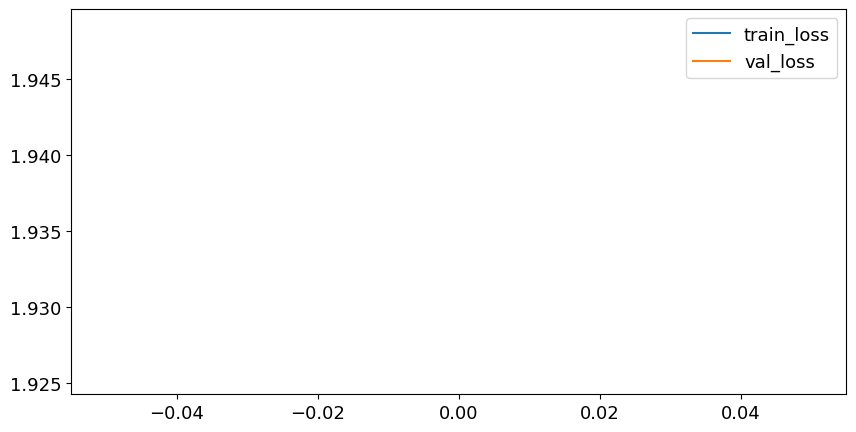

Train accuracy0.1337854500616523.4f
Validation accuracy0.21808510638297873.4f


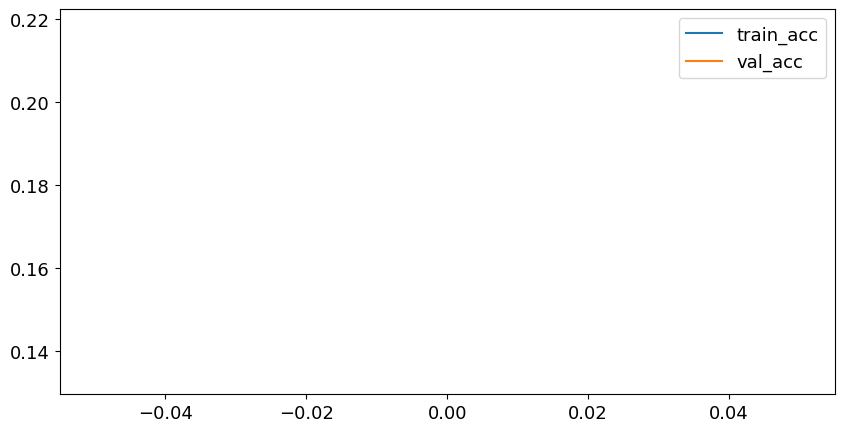

Train loss 1.7241055965423584.4f
Validation_loss 1.722093105316162.4f


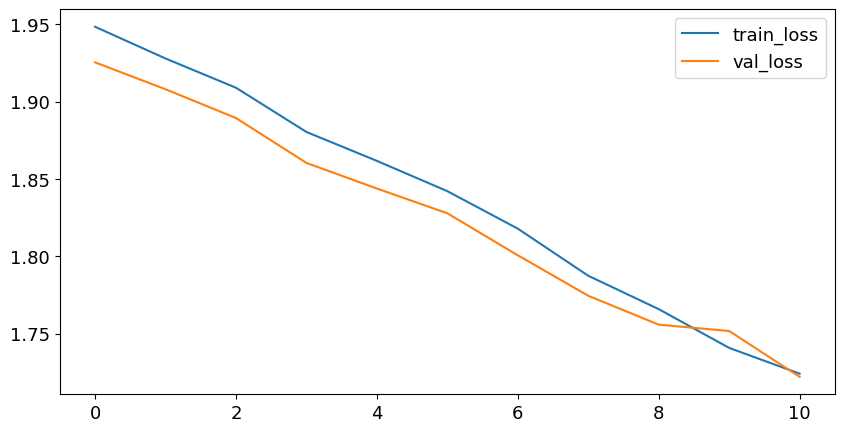

Train accuracy0.5974106041923551.4f
Validation accuracy0.549645390070922.4f


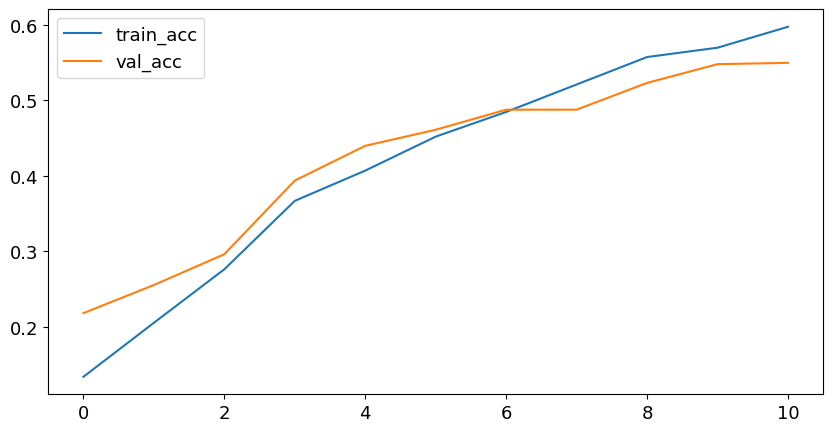

Train loss 1.5614978075027466.4f
Validation_loss 1.6024410724639893.4f


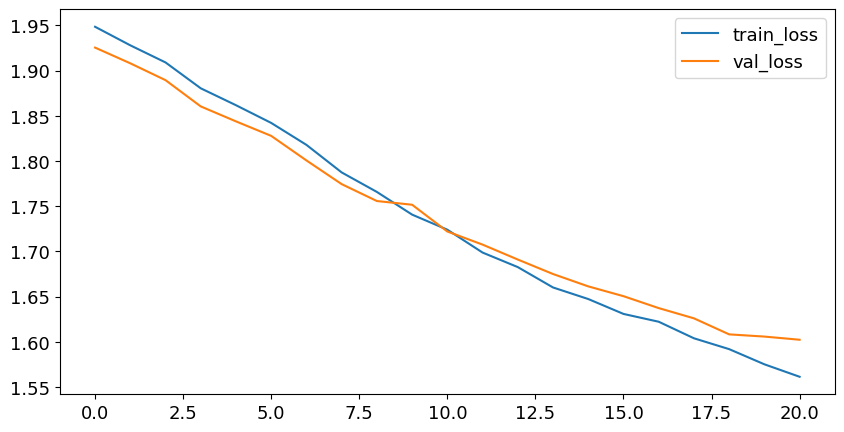

Train accuracy0.689272503082614.4f
Validation accuracy0.6312056737588653.4f


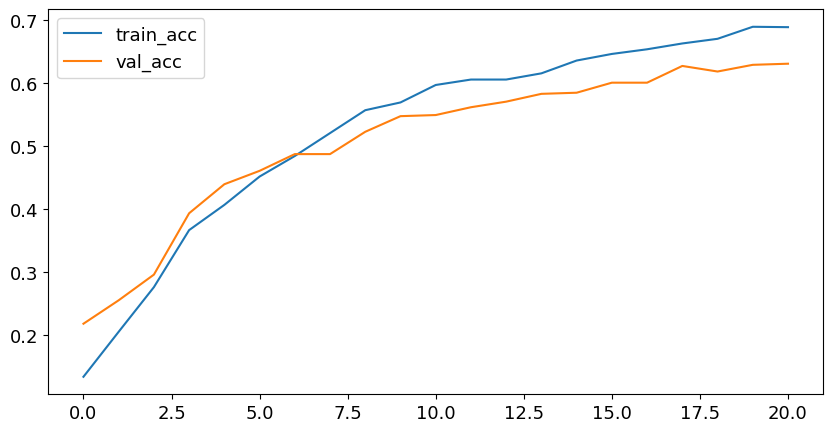

Train loss 1.4581961631774902.4f
Validation_loss 1.5122252702713013.4f


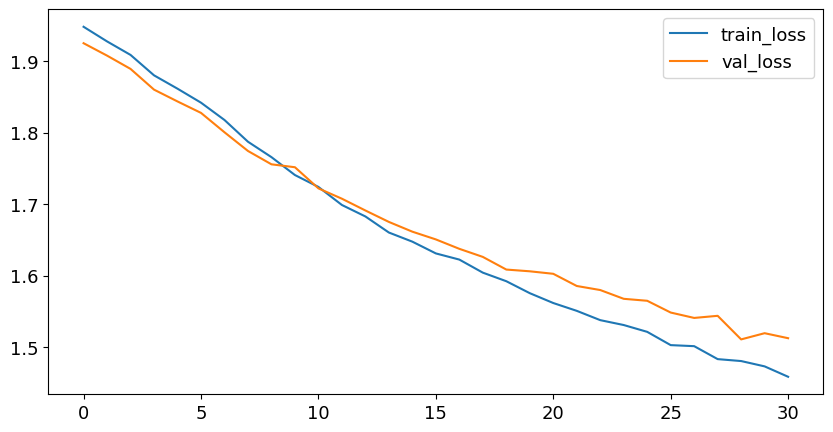

Train accuracy0.7749691738594328.4f
Validation accuracy0.7021276595744681.4f


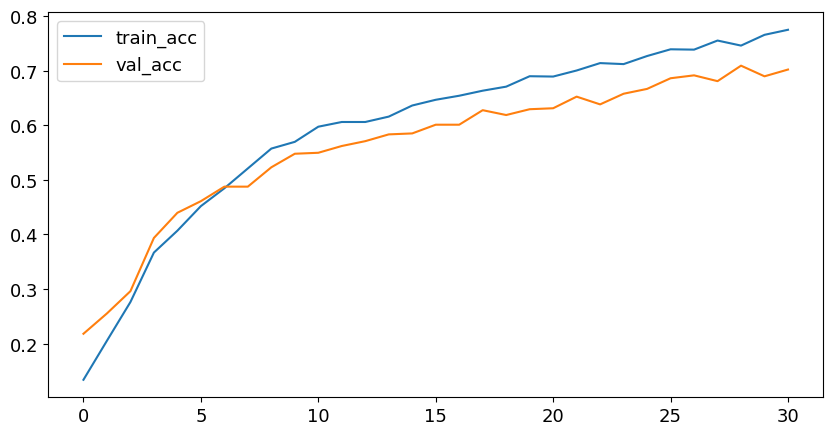

Train loss 1.3998849391937256.4f
Validation_loss 1.4598661661148071.4f


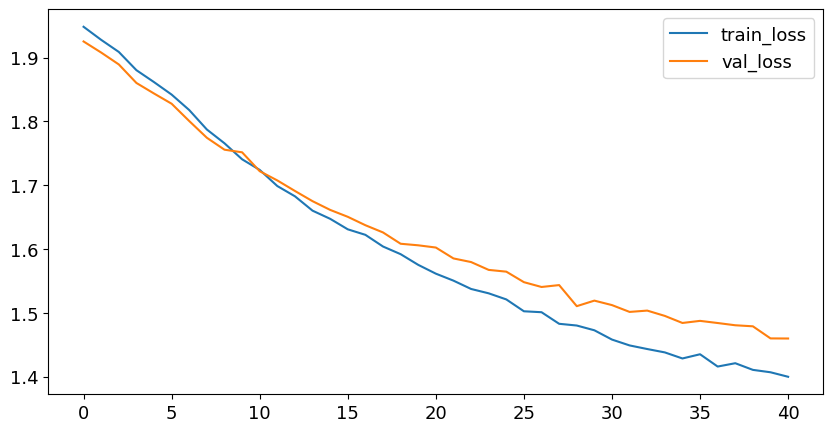

Train accuracy0.8014796547472256.4f
Validation accuracy0.7340425531914894.4f


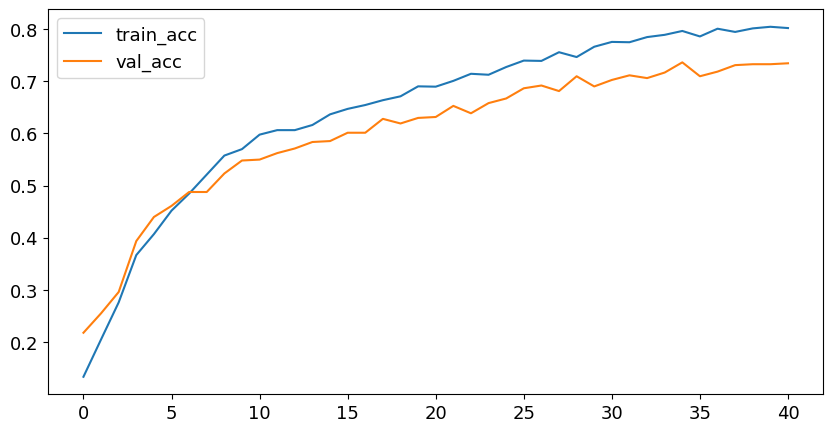

Train loss 1.3677674531936646.4f
Validation_loss 1.4431897401809692.4f


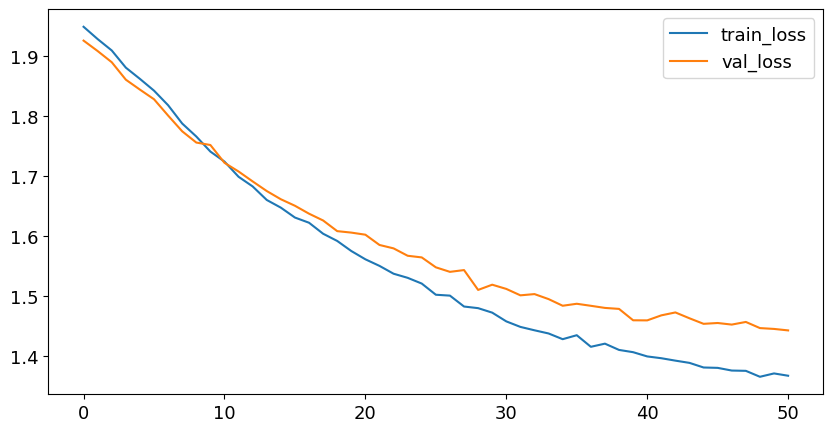

Train accuracy0.8144266337854501.4f
Validation accuracy0.7322695035460993.4f


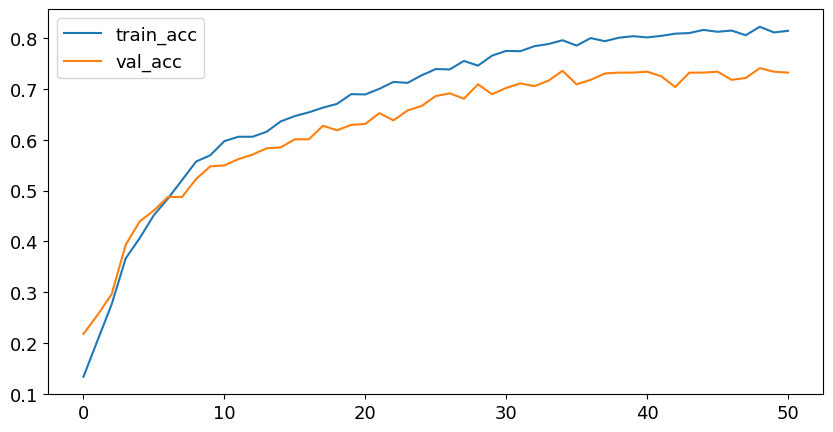

Train loss 1.346882700920105.4f
Validation_loss 1.4497745037078857.4f


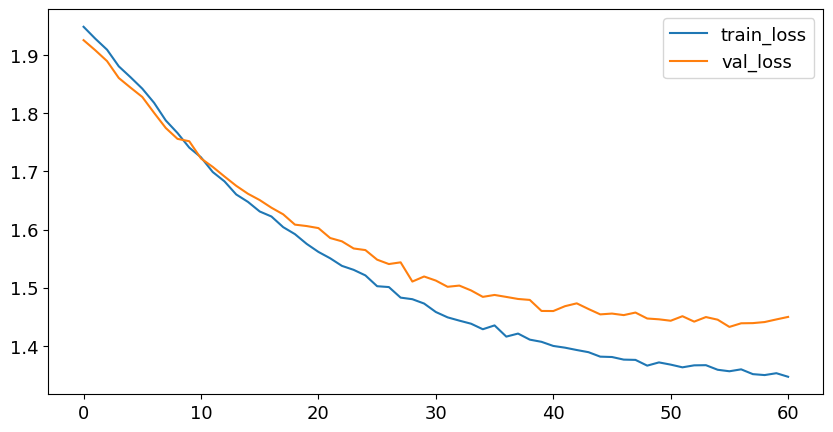

Train accuracy0.8230579531442663.4f
Validation accuracy0.7056737588652482.4f


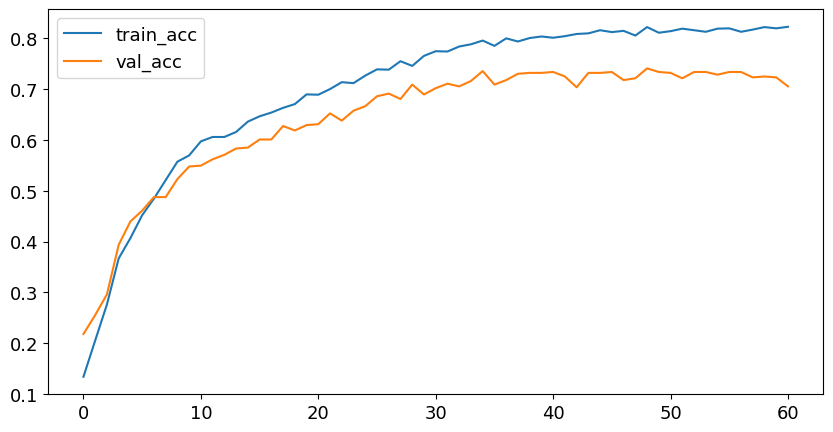

In [ ]:
adjmatrix_torch = torch.from_numpy(adjmatrix).float().to('cuda')
epoch_num = 70
model = Jumping_GCN().to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()
train_loss = 0.0
val_loss = 0.0
train_acc = 0.0
val_acc = 0.0

epochs_train_loss = []
epochs_val_loss = []
epoch_train_acc = []
epoch_val_acc = []

for epoch in range(epoch_num):
  y_pred = model(feature_data, adjmatrix_torch, "train")
  train_loss = loss_fn(y_pred, y_train)
  epochs_train_loss.append(train_loss.cpu().data)


  train_acc = torch.sum(torch.argmax(y_pred, dim=1) == y_train).item() / y_train.shape[0]
  epoch_train_acc.append(train_acc)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  with torch.no_grad():
    y_pred_val = model(feature_data, adjmatrix_torch, "validation")
    val_loss = loss_fn(y_pred_val, y_val)
    epochs_val_loss.append(val_loss.cpu().data)

    val_acc = torch.sum(torch.argmax(y_pred_val, dim=1) == y_val).item() / y_val.shape[0]
    epoch_val_acc.append(val_acc)


  if epoch % 10 == 0:

    print(f'Train loss {train_loss.data}.4f')
    print(f'Validation_loss {val_loss.data}.4f')
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_train_loss, label='train_loss')
    plt.plot(epochs_val_loss, label='val_loss')
    plt.legend()
    plt.show()

    print(f'Train accuracy{train_acc}.4f')
    print(f'Validation accuracy{val_acc}.4f')
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_train_acc, label='train_acc')
    plt.plot(epoch_val_acc, label='val_acc')
    plt.legend()
    plt.show()





In [ ]:
torch.softmax(model.alphas, dim=0)

In [ ]:
embeddings = torch.stack(model.embeddings)

In [ ]:
for i in range(epoch_num):
  plot_embedding_pca(embeddings[i].cpu().detach().numpy(), y_train.cpu())

In [ ]:

plot_embedding_umap(embeddings[-1].cpu().detach().numpy(), y_train.cpu())

In [ ]:
plot_embedding_umap_3d(embeddings[-1].detach().numpy(), y_train)

In [ ]:
model.eval()
y_pred = model(feature_data, adjmatrix_torch, "test")

test_loss = loss_fn(y_pred, y_test)
test_acc = torch.sum(torch.argmax(y_pred, dim=1) == y_test).item() / y_test.shape[0]
print('test loss is {}'.format(test_loss))
print('test acc is {}'.format(test_acc))

In [ ]:
!pip install torcheval

In [ ]:

from torcheval.metrics.functional import multiclass_f1_score

multiclass_f1_score(torch.argmax(y_pred, dim=1), y_test, num_classes=7)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrix

cm = confusion_matrix(torch.argmax(y_pred.cpu(), dim=1), y_test.cpu())
dis = ConfusionMatrix(confusion_matrix=cm)
dis.plot()